# Import Functions

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

%matplotlib inline

# Step 1: Calibrate Camera

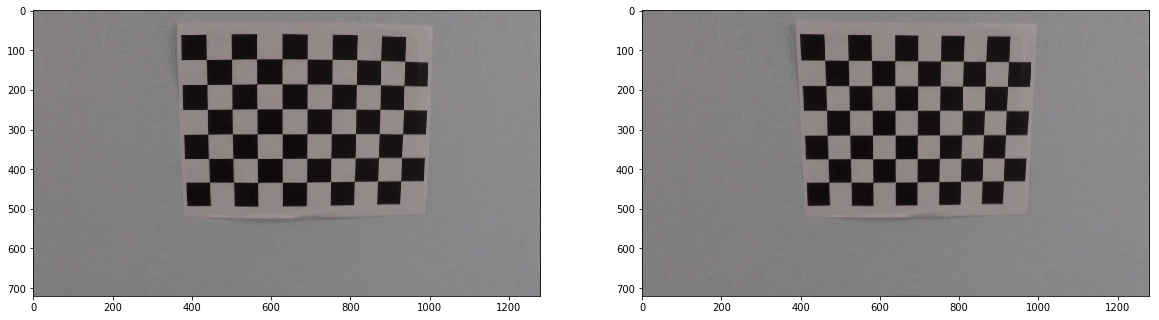

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

example = 'camera_cal/calibration18.jpg'
img = cv2.imread(example)
h, w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
undistorted = cv2.undistort(img, mtx, dist, None, newcameramtx)
fig = plt.figure(figsize = (20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.imshow(undistorted)

# Step 2: Pipeline Helper Functions

In [152]:

def undistort(img):
    h, w = img.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))
    return cv2.undistort(img, mtx, dist, None, newcameramtx)

def sobelx(img, ksize = 5, thresh = 20):
    sobelx = cv2.Sobel(img,cv2.CV_64F, 1, 0, ksize = ksize)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    ret, thresh = cv2.threshold(scaled_sobelx, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_white(img, thresh = 208):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_hlS(img, thresh = 128):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s = hls[:, :, 2]
    ret, thresh = cv2.threshold(s, thresh, 255, cv2.THRESH_BINARY)
    return thresh

def thresh_yellow(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20,50,50])
    upper_yellow = np.array([60,255,255])
    return cv2.inRange(hsv, lower_yellow, upper_yellow)

def transform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[610, 440],[670, 440],[1050, 685]])
    pts2 = np.float32([[dx, w], [dx, 0], [h - dx, 0], [h - dx, w]])

    M = cv2.getPerspectiveTransform(pts1, pts2)

    return cv2.warpPerspective(img, M, (h, w))

def retransform(img):
    h, w = img.shape[:2]
    dx = 200
    pts1 = np.float32([[265, 685],[610, 440],[670, 440],[1050, 685]])
    pts2 = np.float32([[dx, h], [dx, 0], [w - dx, 0], [w - dx, h]])

    M = cv2.getPerspectiveTransform(pts2, pts1)

    return cv2.warpPerspective(img, M, (h, w))

def sliding_window(transformed, leftx_base, rightx_base, nwindows = 10):
    h, w = transformed.shape[:2]
    
    # Set height of windows
    window_height = np.int(h//nwindows)
    
    out_img = np.dstack((transformed, transformed, transformed))
    
    nonzero = transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = h - (window+1)*window_height
        win_y_high = h - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = None, None
    if len(lefty) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

def checkSanity(left_fit, right_fit, ploty):
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    distancex = left_fitx - right_fitx
    distance = np.abs(np.mean(distancex))
    parallel = np.var(distancex)
    
    sane = True
    if distance < 270 or distance > 330:
        sane = False
    if parallel > 60:
        sane = False
        
    return not sane


# Step 3: Pipeline

### Test Images

TypeError: 'NoneType' object is not subscriptable

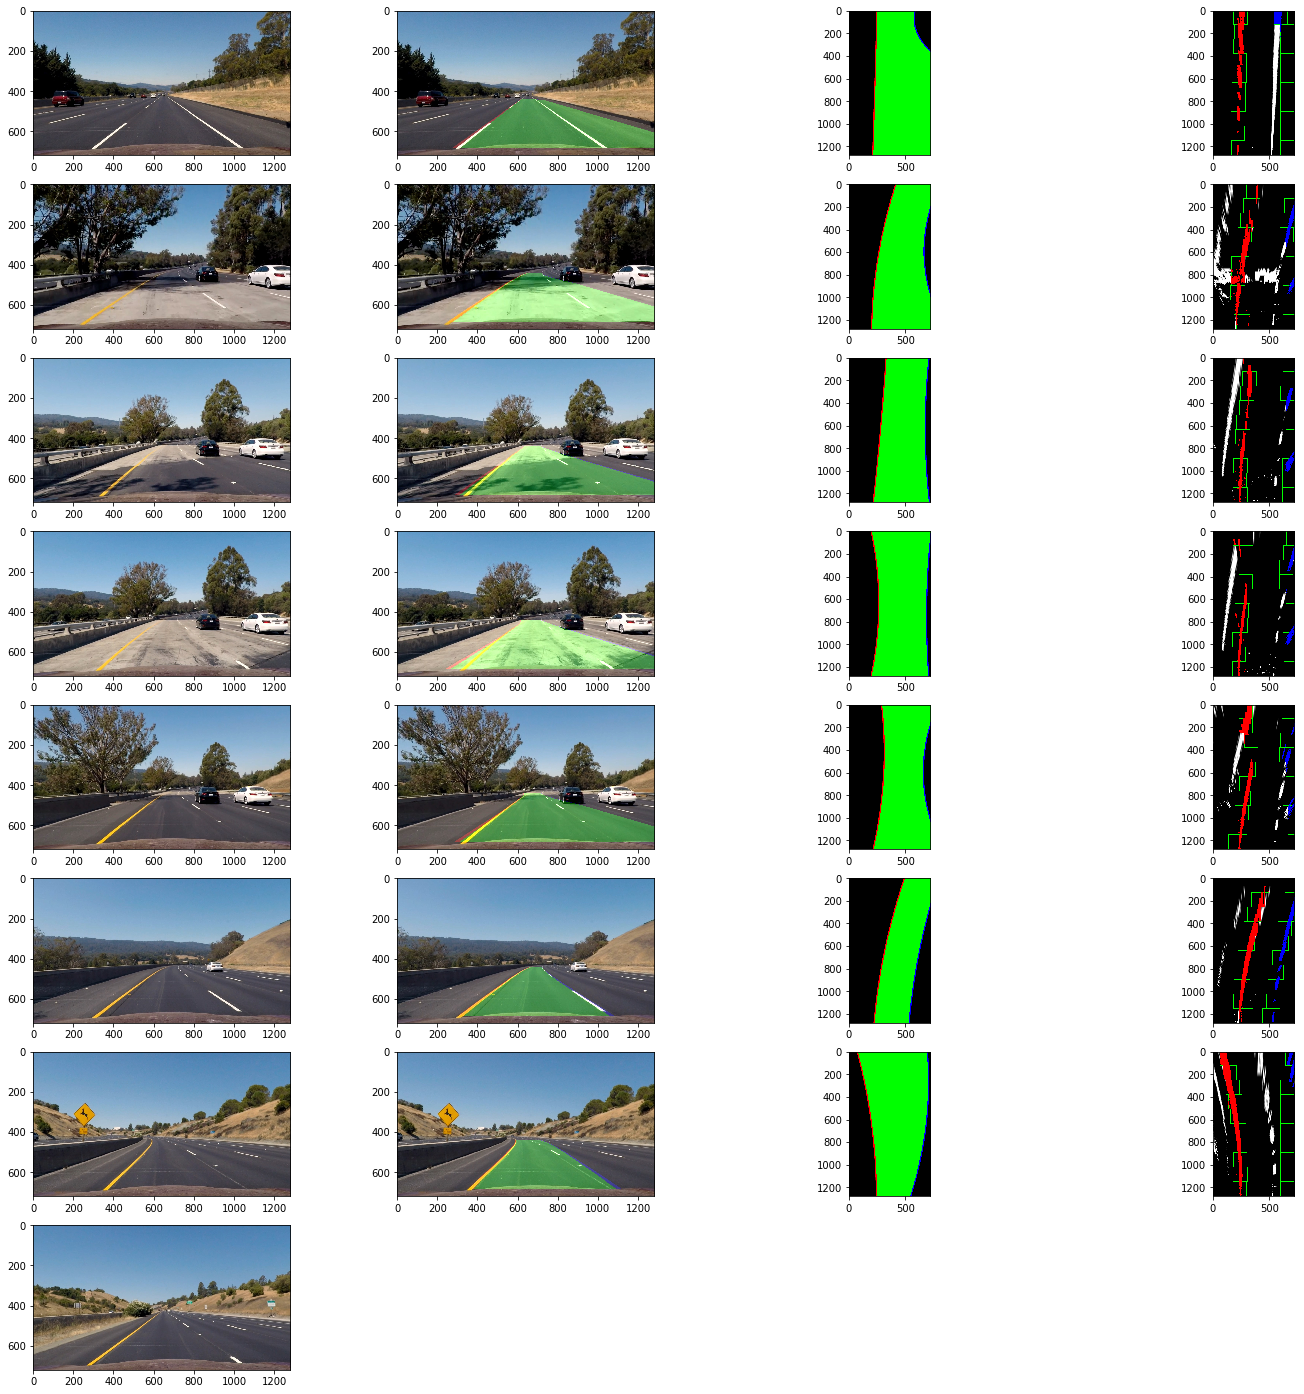

In [153]:

fig = plt.figure(figsize = (25, 25))
for i, fimage in enumerate(glob.glob('test_images/*.jpg')):

    img = undistort(cv2.imread(fimage))
    show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    red = img[:,:,2]
    
    #plot original image
    fig.add_subplot(8, 4, i * 4 + 1)
    plt.imshow(show_img)
    
    sobelr = sobelx(red)
    threshw = thresh_white(img)
    threshs = thresh_hlS(img)
    threshy = thresh_yellow(img)
    
    combined = np.dstack((sobelr, threshs, threshy))
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    
    mask = np.zeros_like(combined_binary)
    pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
    cv2.fillPoly(mask, pts_roi, 255)
    combined_binary = cv2.bitwise_and(combined_binary, mask)
    
    transformed = transform(combined_binary)
    
    histogram = np.sum(transformed[w//3:, h//6:(5*h)//6], axis=0)
    midpoint = np.int(h // 3)
    leftx_base = np.argmax(histogram[:midpoint]) + h // 6
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint + h // 3
    
    left_fit, right_fit, sliding = sliding_window(transformed, leftx_base, rightx_base)
    
    marked_lanes = np.zeros_like(sliding)
    ploty = np.linspace(0, w-1, w )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
    cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
    cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))
    cv2.addWeighted(sliding, 1, marked_lanes, 0.3, 0)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(show_img, 1, retransformed, 0.3, 0)
    
    fig.add_subplot(8, 4, i * 4 + 2)
    plt.imshow(result)
    
    fig.add_subplot(8, 4, i * 4 + 3)
    plt.imshow(marked_lanes)    
    
    fig.add_subplot(8, 4, i * 4 + 4)
    plt.imshow(sliding)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, h)
    #plt.ylim(w, 0)
    
    

### State Class

In [23]:
class State():
    
    def __init__(self):
        self.found = False
        self.left_fit = None
        self.right_fit = None
        self.lanePoly = None


### Pipeline

In [110]:

def pipeline(img):   
    
    #Step 1 Undistort
    img = undistort(img)
    
    #get Params
    h, w = img.shape[:2]
    ploty = np.linspace(0, w-1, w )
    
    #Step 2 Color and Gradients
    red = img[:,:,2]
    sobelr = sobelx(red)
    threshw = thresh_white(img)
    threshs = thresh_hlS(img)
    threshy = thresh_yellow(img)
    
    combined_binary = cv2.bitwise_or(sobelr, threshw)
    combined_binary = cv2.bitwise_or(combined_binary, threshs)
    combined_binary = cv2.bitwise_or(combined_binary, threshy)
    
    #Step 3 ROI
    if state.found:
        mask = cv2.dilate(state.lanePoly, np.ones((19,19), np.uint8), iterations = 1)
    else:
        pts_roi = np.array([[[215, 690],[560, 390],[720, 390],[1100, 690]]], np.int32)
        mask = np.zeros_like(combined_binary)
        cv2.fillPoly(mask, pts_roi, 255)
    masked_binary = cv2.bitwise_and(combined_binary, mask)
    
    #Step 4 Transform
    transformed = transform(combined_binary)
    
    #Step 5 Sliding Window
    if state.found:
        leftx_base = state.left_fit[0]*w**2 + state.left_fit[1]*w + state.left_fit[2]
        rightx_base = state.right_fit[0]*w**2 + state.right_fit[1]*w + state.right_fit[2]
        cv2.circle(transformed, (int(leftx_base), w), 12, 255, -1)  #Mark the base
        cv2.circle(transformed, (int(rightx_base), w), 12, 255, -1)
    else:
        histogram = np.sum(transformed[w//3:, h//6:(5*h)//6], axis=0)
        midpoint = np.int(h // 3)
        leftx_base = np.argmax(histogram[:midpoint]) + h // 6
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint + h // 3
        
    left_fit, right_fit, _ = sliding_window(transformed, leftx_base, rightx_base)
    unsane = checkSanity(left_fit, right_fit, ploty)
    if left_fit is None or unsane and state.found:
        left_fit = state.left_fit
    if right_fit is None or unsane and state.found:
        right_fit = state.right_fit
    
    #Step 6 Draw lines
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #Calculate mean
    if state.found:
        old_left_fitx = state.left_fit[0]*ploty**2 + state.left_fit[1]*ploty + state.left_fit[2]
        old_right_fitx = state.right_fit[0]*ploty**2 + state.right_fit[1]*ploty + state.right_fit[2]
        left_fitx = np.mean((left_fitx, old_left_fitx), axis = 0)
        right_fitx = np.mean((right_fitx, old_right_fitx), axis = 0)
            
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    marked_lanes = np.zeros((w, h, 3), np.uint8)
    lanePoly = np.zeros_like(transformed)
    
    cv2.polylines(marked_lanes, np.int_(pts_left), False, (255, 0, 0), 20, cv2.LINE_AA)
    cv2.polylines(marked_lanes, np.int_(pts_right), False, (0, 0, 255), 20, cv2.LINE_AA)
    cv2.fillPoly(marked_lanes, np.int_([pts]), (0,255, 0))
    cv2.fillPoly(lanePoly, np.int_([pts]), 255)

    retransformed = retransform(marked_lanes)
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, retransformed, 0.3, 0)
    
    #Step 7 Calculate curvature:
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/w # meters per pixel in y dimension
    xm_per_pix = 3.7/290 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*w*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*w*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curverad = np.mean(left_curverad, right_curverad)
    cv2.putText(result,'OpenCV', (10,10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255,255,255), 2, cv2.LINE_AA)
    
    #Step 8 Save parameters
    state.found = True
    state.left_fit = left_fit
    state.right_fit = right_fit
    state.lanePoly = retransform(lanePoly)
    
    return result
    

In [60]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [111]:
state = State()

output = 'output_images/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [05:59<00:00,  3.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 8min 52s, sys: 7.33 s, total: 8min 59s
Wall time: 6min


In [154]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [119]:
state = State()

output2 = 'output_images/challenge_video.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
white_clip = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [02:21<00:00,  3.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 3min 28s, sys: 2.9 s, total: 3min 31s
Wall time: 2min 22s


In [120]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

In [121]:
state = State()

output3 = 'output_images/harder_challenge_video.mp4'

clip3 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip3.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output3, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [06:43<00:00,  3.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

CPU times: user 9min 26s, sys: 7.26 s, total: 9min 33s
Wall time: 6min 45s


In [122]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output3))